# Pneumonia Classification project
### 20185218_김민혁, 20175246_이환주

In [1]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm.auto import tqdm, trange
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets
import splitfolders
import sklearn
from pathlib import Path
import torchvision.models as models
from collections import OrderedDict
import torch.optim as optimizer
from torch.optim.lr_scheduler import StepLR

---

# Data 확인

#### 5세 이하의 폐 dataset

In [147]:
# 모든 데이터가 들어있는 경로
path = './Dataset' 
file_list = os.listdir(path) 
print(file_list)

['NORMAL', 'PNEUMONIA']


# data의 불 균형 정도 확인 대략 1:2.5의 비율로 나타나는 것을 확인 할 수 있음


In [148]:
for k in file_list:
    class_file = os.path.join(path, k)
    print (k, ':', len(os.listdir(class_file)))

NORMAL : 1583
PNEUMONIA : 4274


In [149]:
# transform은 이미지 데이터에 어떤 효과를 적용 시킬 것인지를 정해 놓는것

transform = transforms.Compose([
    transforms.ToTensor(),                                    # 데이터를 Tensor로 바꿈  
    transforms.Resize((224,224)),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))    # 데이터의 정규화
    ])

In [150]:
# dataset이라는 변수에 폴더별로 label을 달아서 가져오는 패키지인 datasets의 ImageFolder를 사용
# root : 데이터들의 경로를 설정
# transform : 데이터들에 적용할 효과 (위에서 정의한 transform) 

dataset = datasets.ImageFolder(
        root='./Dataset',
        transform= transform
    )

In [151]:
Dataset

torch.utils.data.dataset.Dataset

In [152]:
# Dataset - (전체 데이터) 
# DataLoader - (전체 데이터를 batch_size의 크기로 여러 덩어리를 만들어줌)

data_loader = DataLoader(
    dataset,
    batch_size=20,
    shuffle=True
)


# 이미지를 표현하기 위해 만든 함수
def imshow(img):
    img = img * 0.5 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

In [153]:
images, labels = iter(data_loader).next()                           # batch_size크기로 data를 받아옴 (아래 출력문 확인) 
print('Data shape: ', images.shape, '\nLabel Example: ', labels)    # Data의 shape와 Label쌍을 확인


classes = ['Normal', 'Pneumonia']              # 데이터의 label이 0과 1로 지정되어 있어서 출력시 이름을 달아주기 위해 사용
                                               # 추가적으로 폴더의 이름순으로 0, 1, 2, 3, ... 의 index로 잡힘
    
### for display ###
images = images.numpy()                        # convert images to numpy for display

Data shape:  torch.Size([20, 3, 224, 224]) 
Label Example:  tensor([1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0])


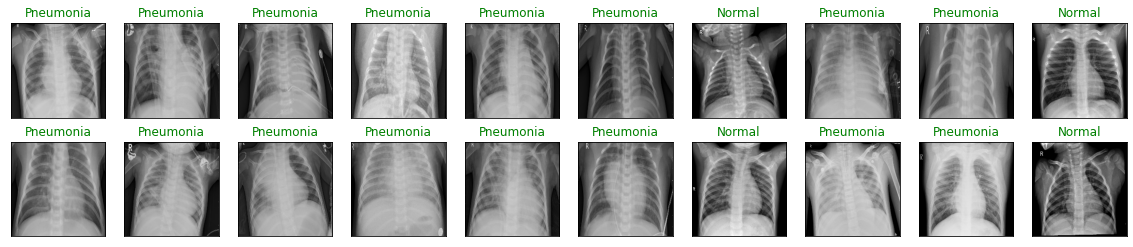

In [154]:
### sample 확인 ###

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]], color='Green')

# Data split

우선 data를 확인 해 봤으니, 전체 데이터를 train, test, 선택적으로 valid 폴더로 나눔

In [10]:
os.getcwd()

'C:\\Users\\hyuk6\\Desktop\\수업\\2021_2\\AISeminar\\final project'

In [11]:
# # splitfolders 에서 ratio 자체를 3개로 주면 train, val, test의 폴더, 2개주면 train,val 2개의 폴더로 해당 비율로 바꿈
# splitfolders.ratio('./Dataset', output='./images', ratio=(0.8, 0.1, 0.1))


### data의 불균형 문제를 완화하기 위해서 지저분한 데이터를 삭제

In [143]:
path1 = './images/train'
path2 = './images/val' 
path3 = './images/test' 

file_list1 = os.listdir(path1) 
file_list2 = os.listdir(path2)
file_list3 = os.listdir(path3)

print(file_list)

['test', 'train', 'val']


In [145]:
print('----------train----------')
for k in file_list1:
    class_file = os.path.join(path1, k)
    print (k, ':', len(os.listdir(class_file)))
    
print('----------val----------')
    
for k in file_list2:
    class_file = os.path.join(path2, k)
    print (k, ':', len(os.listdir(class_file)))
    
print('----------test----------')
    
for k in file_list3:
    class_file = os.path.join(path3, k)
    print (k, ':', len(os.listdir(class_file)))

----------train----------
NORMAL : 1266
PNEUMONIA : 1682
----------val----------
NORMAL : 158
PNEUMONIA : 203
----------test----------
NORMAL : 159
PNEUMONIA : 203


---------------------

# Dada loader 생성 *

In [12]:
## Create the data loader

# current work directory (trian folder, test folder, : validation folder 의 상위 폴더 경로)
cwd = Path('./images')

def load_dataset(cwd, form, batch_size):           # form ->  (train | test :| valid)
    data_path = os.path.join(cwd, form)
    dataset = datasets.ImageFolder(
        root=data_path,
        transform= chosen_transforms[form]
    )
    data_loader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=0,
        shuffle=True
    )
    return data_loader, len(dataset), dataset.classes

In [13]:
chosen_transforms = {
    'train' : transforms.Compose([
                transforms.ToTensor(),                                    # 데이터를 Tensor로 바꿈  
                transforms.Resize((224, 224)),
                ]),
    'test' : transforms.Compose([
                transforms.ToTensor(),                                    # 데이터를 Tensor로 바꿈  
                transforms.Resize((224,224)),
                ]),
}

train_loader, train_size, classname = load_dataset(cwd, 'train', 64)
test_loader, test_size, classname = load_dataset(cwd, 'test', 20)

In [16]:
train_X, train_Y = next(iter(train_loader))
test_X, test_Y = next(iter(test_loader))


print('Train ------------')
print('train batch shape : ', train_X.shape)
print('train size : ', train_size)
print('train label shape : ', train_Y.shape)
print('------------------------------------------------------')

print()
print('test  ------------')
print('test batch shape : ', test_X.shape)
print('test size : ', test_size)
print('test label shape : ', test_Y.shape)
print('------------------------------------------------------')
print('class name : ', classname)

Train ------------
train batch shape :  torch.Size([64, 3, 224, 224])
train size :  2948
train label shape :  torch.Size([64])
------------------------------------------------------

test  ------------
test batch shape :  torch.Size([20, 3, 224, 224])
test size :  362
test label shape :  torch.Size([20])
------------------------------------------------------
class name :  ['NORMAL', 'PNEUMONIA']


---

# Normalization 을 위한 mean과 std를 구하기

In [14]:
use_cuda = torch.cuda.is_available()
use_cuda

True

In [15]:
cnt = 0
mean = 0.
std = 0.
for images, label in tqdm(train_loader):

    if(use_cuda):
        images = images.cuda()
    images = images.view(images.size(0), images.size(1), -1)

    cnt += images.size(0)
    # 각 batch당 색깔별 mean, std를 구해 mean, std 변수에 합쳐서 저장
    mean += images.mean(2).sum(0) 
    std += images.std(2).sum(0)

# 사진의 개수로 위에서 더한 mean값을 나눠줌
mean /= cnt
std /= cnt



print('Mean : ', mean)
print('Std : ', std)

  0%|          | 0/47 [00:00<?, ?it/s]

Mean :  tensor([0.4812, 0.4812, 0.4812], device='cuda:0')
Std :  tensor([0.2272, 0.2272, 0.2272], device='cuda:0')


---

# Pretrained Model 불러오기 *

In [17]:
# model_transfer = models.wide_resnet50_2(pretrained=True)
# model_transfer = models.resnet152(pretrained=True)
model_transfer = models.wide_resnet101_2(pretrained=True)
# model_transfer = models.resnext101_32x8d(pretrained=True)


In [18]:
mean = [0.4807, 0.4807, 0.4807]
std = [0.2233, 0.2233, 0.2233]
IMAGE_SIZE = 224
classes = ['Normal', 'Pneumonia']

In [19]:
train_path = os.path.join(cwd, 'train')
valid_path = os.path.join(cwd, 'val')
test_path  = os.path.join(cwd, 'test')

In [20]:

transfer_train_transforms = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                                transforms.ToTensor(),
                                                # transforms.RandomRotation(degrees=(0, 40)),
                                                transforms.RandomHorizontalFlip(p=0.5),
                                                transforms.ColorJitter(contrast=(0.2, 1), brightness=(0.8, 1.1)),
                                                transforms.Normalize(mean, std)
                                               ])

transfer_test_transforms = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                               transforms.ToTensor(),
                                               transforms.Normalize(mean, std)
                                              ])
# Image folder

transfer_training = datasets.ImageFolder(train_path, transform=transfer_train_transforms)
transfer_validation = datasets.ImageFolder(valid_path, transform=transfer_test_transforms)
transfer_testing = datasets.ImageFolder(test_path, transform=transfer_test_transforms)


# DataLoader

transfer_train_batches =  torch.utils.data.DataLoader(transfer_training, batch_size=64, shuffle = True)
transfer_valid_batches =  torch.utils.data.DataLoader(transfer_validation, batch_size=64, shuffle = False)
transfer_test_batches =  torch.utils.data.DataLoader(transfer_testing, batch_size=5, shuffle = False)


for param in model_transfer.parameters():
    param.requires_grad = False

    
fc = nn.Sequential(OrderedDict([('fc1', nn.Linear(2048, 1000)),
                                ('bn1', nn.BatchNorm1d(1000)),
                                ('ReLU', nn.ReLU()),
                                ('fc2', nn.Linear(1000, 700)),
                                ('bn2', nn.BatchNorm1d(700)),
                                ('ReLU', nn.ReLU()),
                                ('dropout', nn.Dropout(0.35)),
                                ('fc3', nn.Linear(700, 200)),
                                ('bn3', nn.BatchNorm1d(200)),
                                ('ReLU', nn.ReLU()),
                                ('fc4', nn.Linear(200, len(classes)))]))

model_transfer.fc = fc

# cuda 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_transfer.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), strid

In [21]:
a , b = next(iter(transfer_train_batches))
a.size()

torch.Size([64, 3, 224, 224])

---

# Train *

## Train 함수 정의

In [22]:
def train(n_epochs, train_loader, valid_loader, model, optimizer, scheduler, criterion, use_cuda, save_path):

    n_epoch = n_epochs

    train_losses = []
    valid_losses = []

    valid_loss_min = np.Inf 


    for epoch in tqdm(range(1, n_epoch+1)):

        train_loss = 0.0
        valid_loss = 0.0
    
        ###################
        # train the model #
        ###################

        model.train()

        for data, target in train_loader:

            if use_cuda:
                data, target = data.cuda(), target.cuda()
          
            optimizer.zero_grad()
          
            output = model(data)

            loss = criterion(output, target)

            loss.backward()
            
            optimizer.step()
          
            train_loss += loss.item()*data.size(0)
       
        ######################    
        # validate the model #
        ######################

        model.eval()

        for data, target in valid_loader:

            if use_cuda:
                data, target = data.cuda(), target.cuda()

            output = model(data)

            loss = criterion(output, target)

            valid_loss += loss.item()*data.size(0)
    
        scheduler.step()

        
        train_loss = train_loss/len(train_loader.sampler)
        valid_loss = valid_loss/len(valid_loader.sampler)
        
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))

        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min, valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
            
     
    return model, train_losses, valid_losses


## optimizer & loss fucntion (+scheduler)

In [23]:
criterion_transfer = torch.nn.CrossEntropyLoss()
optimizer_transfer = optimizer.Adam(model_transfer.parameters(), lr=1e-4)
scheduler_transfer = StepLR(optimizer=optimizer_transfer ,step_size=50, gamma=0.1)

## Model Train

In [24]:
epochs = 50
use_cuda = torch.cuda.is_available()

model_path = Path("models").expanduser()
save_path = model_path.joinpath("wide_resnet.pt")

model_transfer, train_losses, valid_losses = train(epochs, transfer_train_batches, transfer_valid_batches, model_transfer, optimizer_transfer, scheduler_transfer, criterion_transfer, use_cuda, save_path)

model_transfer.load_state_dict(torch.load(save_path))

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 	Training Loss: 0.279813 	Validation Loss: 0.566832
Validation loss decreased (inf --> 0.566832).  Saving model ...
Epoch: 2 	Training Loss: 0.204819 	Validation Loss: 0.218766
Validation loss decreased (0.566832 --> 0.218766).  Saving model ...
Epoch: 3 	Training Loss: 0.190386 	Validation Loss: 0.178186
Validation loss decreased (0.218766 --> 0.178186).  Saving model ...
Epoch: 4 	Training Loss: 0.165420 	Validation Loss: 0.178437
Epoch: 5 	Training Loss: 0.162836 	Validation Loss: 0.312737
Epoch: 6 	Training Loss: 0.146633 	Validation Loss: 0.160087
Validation loss decreased (0.178186 --> 0.160087).  Saving model ...
Epoch: 7 	Training Loss: 0.134565 	Validation Loss: 0.143831
Validation loss decreased (0.160087 --> 0.143831).  Saving model ...
Epoch: 8 	Training Loss: 0.122249 	Validation Loss: 0.224932
Epoch: 9 	Training Loss: 0.129083 	Validation Loss: 0.229983
Epoch: 10 	Training Loss: 0.133100 	Validation Loss: 0.130680
Validation loss decreased (0.143831 --> 0.130680)

<All keys matched successfully>

---

### Loss Checking

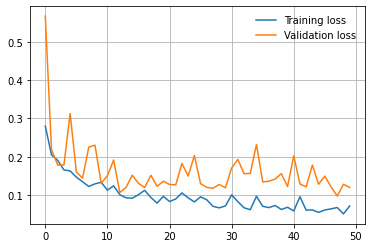

In [25]:
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend(frameon=False)
plt.grid(True)

## load model *

In [26]:
# 저장된 optimal한 model의 weight를 현재 model에 대입
model_path = Path("models").expanduser()
save_path = model_path.joinpath("wide_resnet.pt")
model_transfer.load_state_dict(torch.load(save_path))

<All keys matched successfully>

# Test *

## Test 함수 정의 *

In [27]:
def test(test_loader, model, criterion, use_cuda):
    fail = []
    # test loss 를 만들어 줍니다.
    test_loss = 0.0

    # 분류를 성공한 개수를 알려줄 class_correct를 만들어 줍니다.
    class_correct = list(0. for i in range(len(classes)))
    
    # image의 개수를 count하기위해 class_total을 만들어 줍니다.
    class_total = list(0. for i in range(len(classes)))

    # parameter들을 업데이트 하지 않기 때문에 model.eval()
    model.eval()
    
    # testloader에서 image와 label을 가져 옵니다.
    for data, target in tqdm(test_loader):
    
        # CUDA가 사용 가능하다면, GPU로 가져온 data를 옮깁니다.
        if use_cuda:
            data, target = data.cuda(), target.cuda()
    
        # forward pass: model에 image 를 넣고, 결과값을 output에 저장 
        output = model(data)
    
        # batch의 loss를 계산합니다.
        loss = criterion(output, target)
    
        # batch의 loss를 통해 test loss를 update해 줍니다. 
        test_loss += loss.item()*data.size(0)
    
        # batch 단위로 output의 값의 index를 pred에 저장합니다. (class에 해당합니다.)
        _, pred = torch.max(output, 1)  
        
        # pred의 값이 목적값이랑 같다면 true를, 아니라면 false를 correct_tensor에 저장
        correct_tensor = pred.eq(target.data.view_as(pred))
        
        # tensor -> numpy
        correct = np.squeeze(correct_tensor.numpy()) if not use_cuda else np.squeeze(correct_tensor.cpu().numpy())
        
        # test set의 정확도를 계산
        batch_size = len(target.data)
        for i in range(batch_size):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1
        for i in range(batch_size):
            if not correct[i]:
                fail.append(data[i])
                
    # 지금까지 더해왔던 test loss의 평균
    test_loss = test_loss/len(test_loader.dataset)
    print('Test Loss: {:.6f}\n'.format(test_loss))
    
    # test 결과 출력
    print('Nomal dataset : {}/{}, Pneumonia : {}/{}'.format(int(class_correct[0]), int(class_total[0]), int(class_correct[1]), int(class_total[1])))
    print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (100. * np.sum(class_correct) / np.sum(class_total), np.sum(class_correct), np.sum(class_total)))
    return fail

In [28]:
use_cuda = torch.cuda.is_available()
fail = test(transfer_test_batches, model_transfer, criterion_transfer, use_cuda)

  0%|          | 0/73 [00:00<?, ?it/s]

Test Loss: 0.147450

Nomal dataset : 152/159, Pneumonia : 193/203

Test Accuracy (Overall): 95% (345/362)


# Predict *

In [29]:
from matplotlib import pyplot as plt
mean = [0.4807, 0.4807, 0.4807]
std = [0.2233, 0.2233, 0.2233]
    
def imshow(img):
    for i in range(3):
        img[i] *= std[i]
        img[i] += mean[i]
        
    plt.imshow(np.transpose(img, (1, 2, 0)))  
    
def predict(test_path, model, image_size, rc):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
    
    
    transfer_test_transforms = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                               transforms.ToTensor(),
                                               transforms.Normalize(mean, std)
                                              ])
    transfer_testing = datasets.ImageFolder(test_path, transform=transfer_test_transforms)
    transfer_test_batches =  torch.utils.data.DataLoader(transfer_testing, batch_size=rc[0]*rc[1], shuffle =True)
    img = next(iter(transfer_test_batches))

    fig = plt.figure(figsize=(20, rc[0]*rc[1]))
    label = img[1].detach().cpu().numpy().reshape(-1)
    model = model.to(device)
    img = img[0].to(device)
    with torch.no_grad():
        output = model(img)
    ps = torch.exp(output)
    top_p, top_class = ps.topk(1, dim=1)
    top_class = top_class.detach().cpu().numpy().reshape(-1)
    target_list = ['NORMAL', 'PNEUMONIA']
    for idx in np.arange(len(top_class)):
        ax = fig.add_subplot(rc[0], rc[1], idx+1, xticks=[], yticks=[])
        imshow(img.cpu()[idx])
        ax.set_title('label : {} \npredict : {}'.format(target_list[label[idx]], target_list[top_class[idx]]), color='Green')

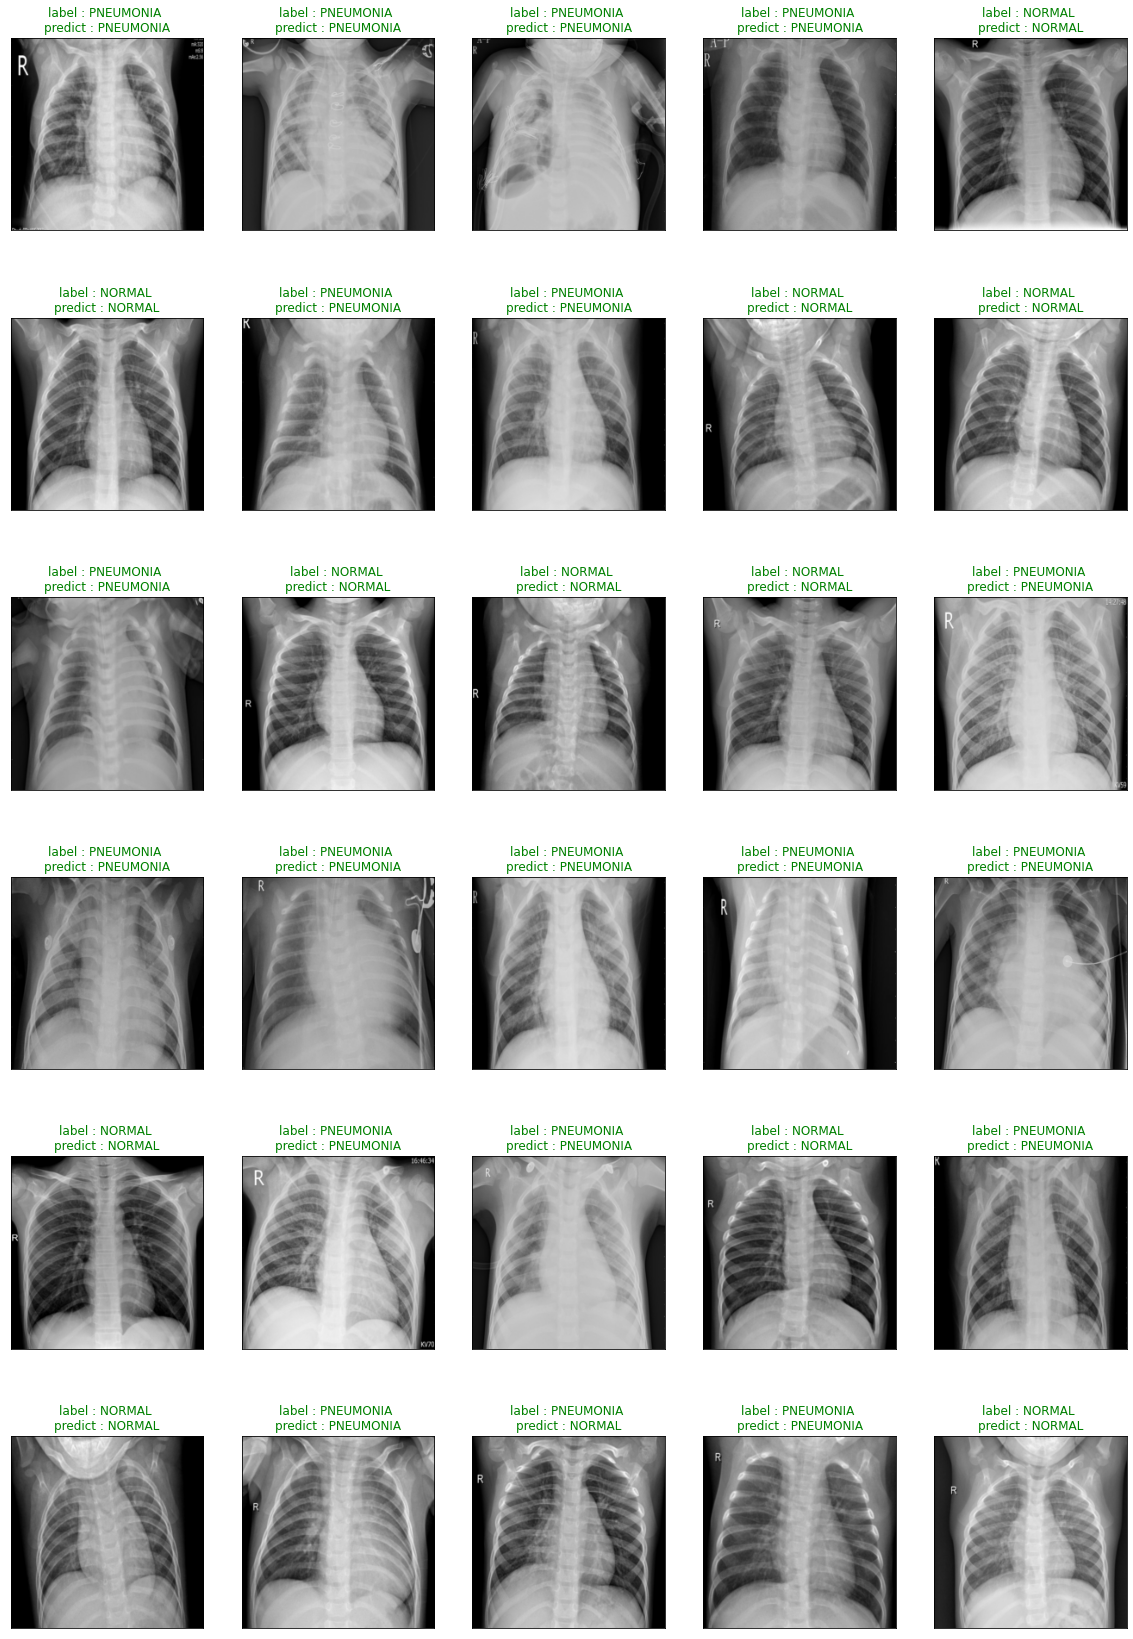

In [30]:
predict(test_path, model_transfer, 224, rc=(6, 5))

# Grad cam 구현 과정

In [31]:
mean = [0.4807, 0.4807, 0.4807]
std = [0.2233, 0.2233, 0.2233]

model_transfer = models.wide_resnet101_2(pretrained=True)

transfer_test_transforms = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                               transforms.ToTensor(),
                                               transforms.Normalize(mean, std)
                                              ])
# Image folder

transfer_training = datasets.ImageFolder(train_path, transform=transfer_train_transforms)
transfer_validation = datasets.ImageFolder(valid_path, transform=transfer_test_transforms)
transfer_testing = datasets.ImageFolder(test_path, transform=transfer_test_transforms)


# DataLoader

transfer_train_batches =  torch.utils.data.DataLoader(transfer_training, batch_size=64, shuffle = True)
transfer_valid_batches =  torch.utils.data.DataLoader(transfer_validation, batch_size=64, shuffle = False)
transfer_test_batches =  torch.utils.data.DataLoader(transfer_testing, batch_size=5, shuffle = False)


for param in model_transfer.parameters():
    param.requires_grad = False

    
fc = nn.Sequential(OrderedDict([('fc1', nn.Linear(2048, 1000)),
                                ('bn1', nn.BatchNorm1d(1000)),
                                ('ReLU', nn.ReLU()),
                                ('fc2', nn.Linear(1000, 700)),
                                ('bn2', nn.BatchNorm1d(700)),
                                ('ReLU', nn.ReLU()),
                                ('dropout', nn.Dropout(0.35)),
                                ('fc3', nn.Linear(700, 200)),
                                ('bn3', nn.BatchNorm1d(200)),
                                ('ReLU', nn.ReLU()),
                                ('fc4', nn.Linear(200, len(classes)))]))

model_transfer.fc = fc

# cuda 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_transfer.to(device)

# 저장된 optimal한 model의 weight를 현재 model에 대입
model_path = Path("models").expanduser()
save_path = model_path.joinpath("wide_resnet.pt")
model_transfer.load_state_dict(torch.load(save_path))

<All keys matched successfully>

In [32]:
class GReLUInner(torch.autograd.Function):
    # forward and backward functions for Guided Backpropagation
        
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        return input * (input > 0).float()
    
    @staticmethod
    def backward(ctx, grad_output):
        input = ctx.saved_tensors
        return grad_output * (grad_output > 0).float() * (input[0] > 0).float()

In [33]:
class GuidedReluModel(nn.Module, GReLUInner):
    def __init__(self):
        super(GuidedReluModel,self).__init__()
        self.guided_relu = GReLUInner.apply
    
    def forward(self, input):
        return self.guided_relu(input)
    
    def backward(ctx, grad_output):
        return self.guided_relu(grad_output)

In [34]:
guide = GuidedReluModel()

In [35]:
def convert_relu_to_softplus(model):
    for child_name, child in model.named_children():
        if isinstance(child, nn.ReLU):
            setattr(model, child_name, guide)
        else:
            convert_relu_to_softplus(child)
            
convert_relu_to_softplus(model_transfer)

In [36]:
import torch
import cv2
import numpy as np
from torchsummary import summary
from torch.nn import functional as F

class ModelOutputs_resnet():
    def __init__(self, model, target_layers, target_sub_layers):
        self.model = model
        self.target_layers = target_layers
        self.target_sub_layers = target_sub_layers
        self.gradients = []

    def save_gradient(self, grad):
        self.gradients.append(grad)

    def get_gradients(self):
        return self.gradients

    def __call__(self, x):
        self.gradients = []
        for name, module in self.model.named_children(): # 모든 layer에 대해서 직접 접근
            x = module(x)
            if name== 'avgpool': 
                x = torch.flatten(x,1)
            if name in self.target_layers: 
                for sub_name, sub_module in module[len(module)-1].named_children():
                    if sub_name in self.target_sub_layers:
                        x.register_hook(self.save_gradient) 
                        target_feature_maps = x
        return target_feature_maps, x 


class GradCam_resnet:
    def __init__(self, model, target_layer_names,target_sub_layer_names, use_cuda):
        self.model = model
        self.model.eval()
        self.cuda = use_cuda
        if self.cuda:  # GPU일 경우 model을 cuda로 설정
            self.model = model.cuda()

        self.extractor = ModelOutputs_resnet(self.model, target_layer_names, target_sub_layer_names)

    def forward(self, input):
        return self.model(input)

    def __call__(self, input, index=None):
        
        if self.cuda:  # GPU일 경우 input을 cuda로 변환하여 전달
            features, output = self.extractor(input.cuda())
        else:
            features, output = self.extractor(input)

        probs,idx = 0, 0
        if index == None:
            index = np.argmax(output.cpu().data.numpy())  # index = 정답이라고 추측한 class index
            h_x = F.softmax(output,dim=1).data.squeeze()
            probs, idx = h_x.sort(0, True)


        one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
        one_hot[0][index] = 1  # 정답이라고 생각하는 class의 index 리스트 위치의 값만 1로
        one_hot = torch.from_numpy(one_hot).requires_grad_(True)  # numpy배열을 tensor로 변환
        # requires_grad == True 텐서의 모든 연산에 대하여 추적
        if self.cuda:
            one_hot = torch.sum(one_hot.cuda() * output)
        else:
            one_hot = torch.sum(one_hot * output)

        self.model.zero_grad()
        one_hot.backward(retain_graph=True)

        grads_val = self.extractor.get_gradients()[-1].cpu().data.numpy()

        target = features  # A^k

        target_cam = target.cpu().data.numpy()
        bz, nc, h,w = target_cam.shape

        target = target.cpu().data.numpy()[0, :]


        weights = np.mean(grads_val, axis=(2, 3))[0, :]  
        grad_cam = np.zeros(target.shape[1:], dtype=np.float32)  

        for i, w in enumerate(weights): 
            grad_cam += w * target[i, :, :]  # linear combination L^c_{Grad-CAM}에 해당하는 식에서 ReLU를 제외한 식

        grad_cam = np.maximum(grad_cam, 0)  # 0보다 작은 값을 제거
        grad_cam = cv2.resize(grad_cam, (224, 224))  # 224X224크기로 변환
        grad_cam = grad_cam - np.min(grad_cam)  #
        grad_cam = grad_cam / np.max(grad_cam)  # 위의 것과 해당 줄의 것은 0~1사이의 값으로 정규화하기 위한 정리
        return grad_cam ,index, probs, idx ,

# Grad cam 결과

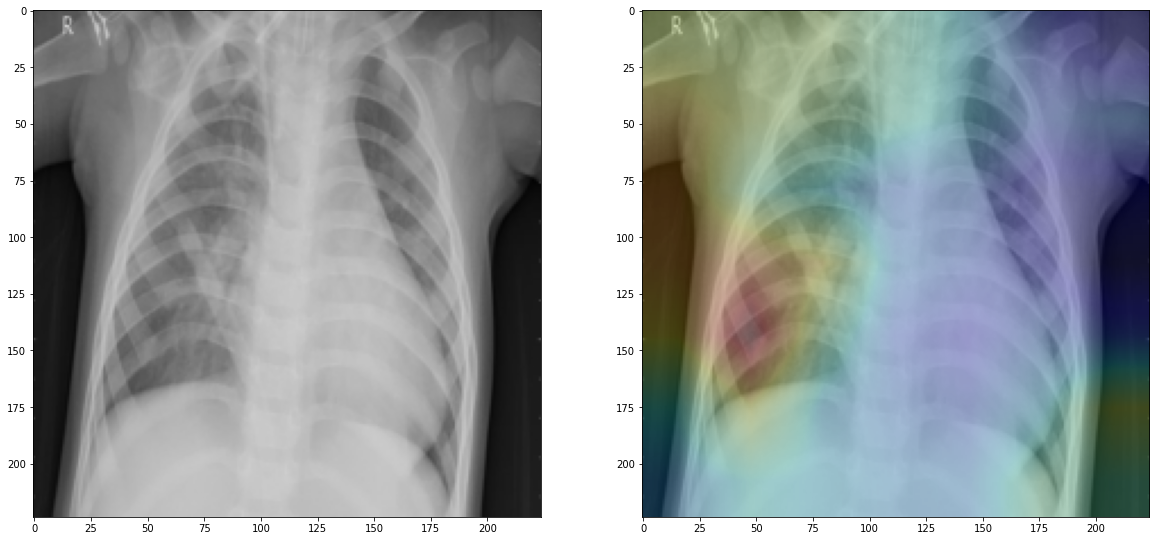

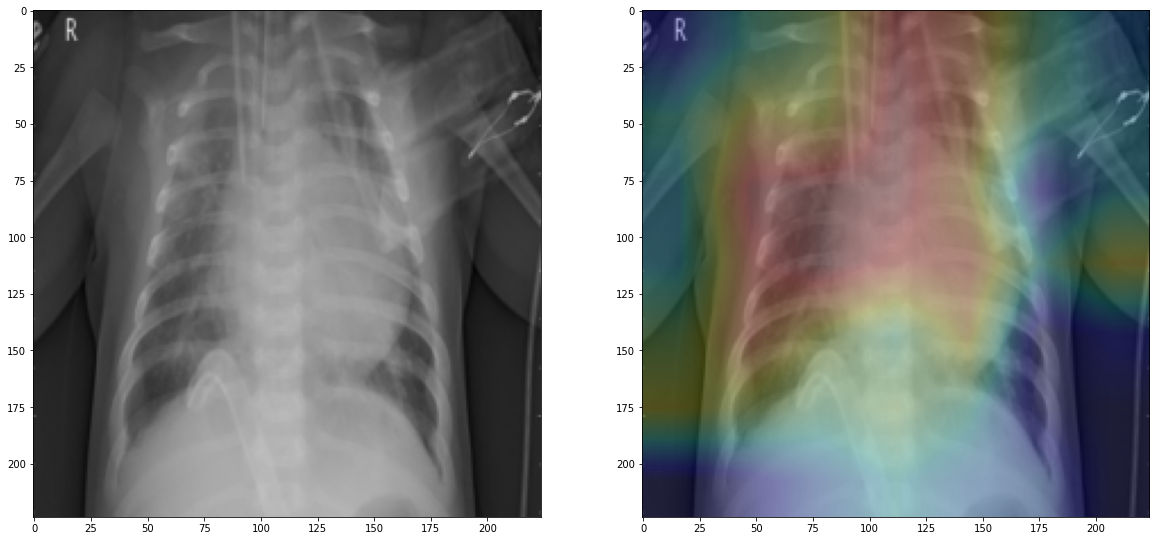

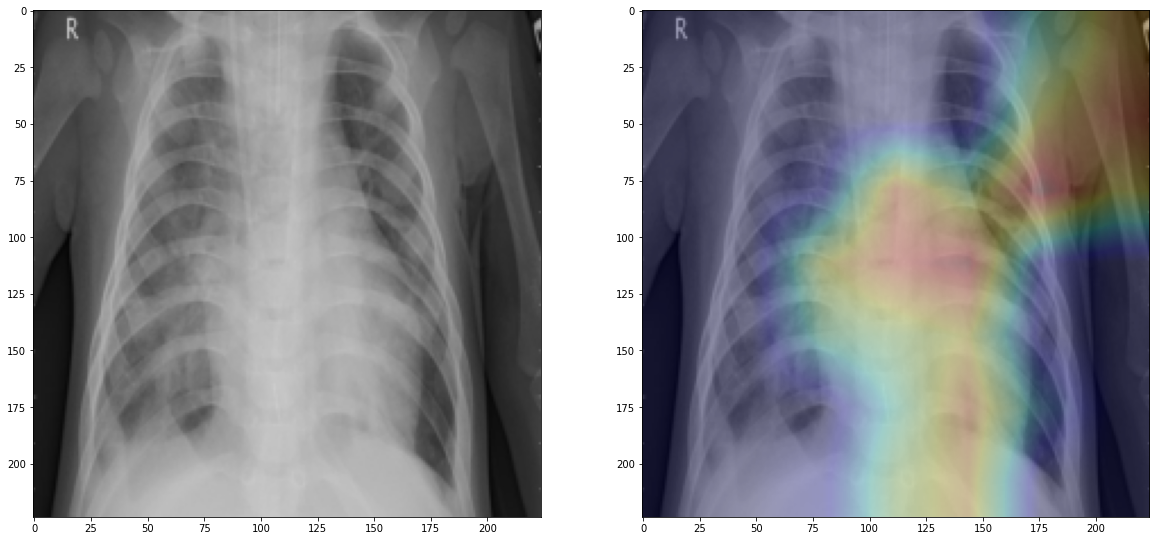

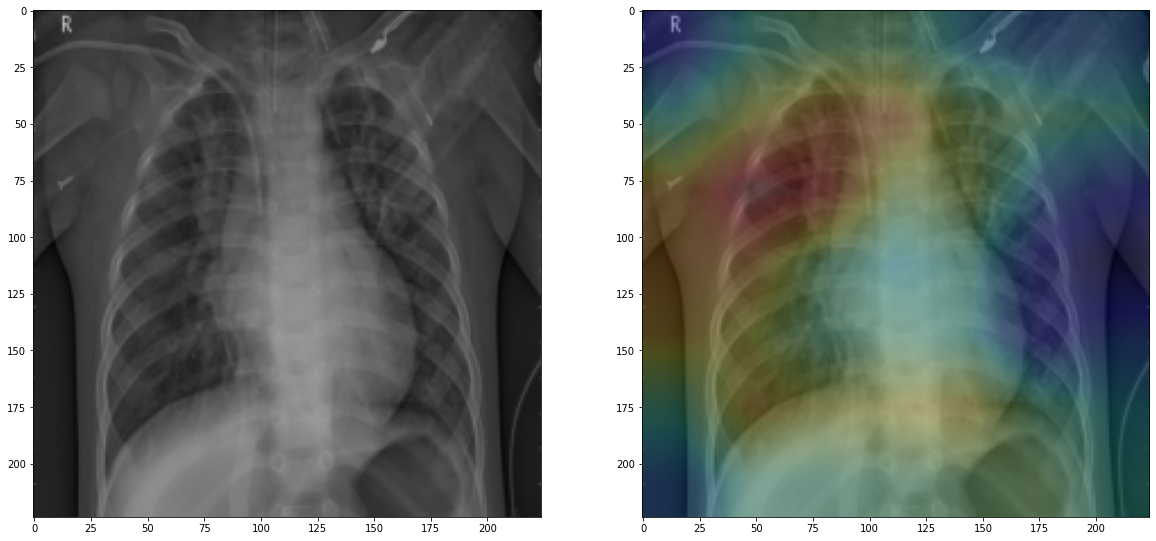

In [118]:
transfer_test_transforms = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                               transforms.ToTensor(),
                                               transforms.Normalize(mean, std)
                                              ])
transfer_testing = datasets.ImageFolder(test_path, transform=transfer_test_transforms)
test_loader =  torch.utils.data.DataLoader(transfer_testing, batch_size=5,shuffle =True)
image = next(iter(test_loader))
img, label = image[0].requires_grad_(requires_grad=True), image[1]
grad_cam = GradCam_resnet(model_transfer, 'layer4', 'relu', use_cuda) 
gc, i, p, ix = grad_cam(img, label)
mean = [0.4807, 0.4807, 0.4807]
std = [0.2233, 0.2233, 0.2233]
def imshow(img): 
    for i in range(3):
        img[i] *= std[i]
        img[i] += mean[i]
    plt.imshow(np.transpose(img, (1, 2, 0)))  
    
def ishow(img): 
    plt.imshow(np.transpose(img, (1, 2, 0)))  


for i in range(5):
    if label[i] != 1:
        continue
    plt.figure(figsize=(20,20))
    plt.subplot(1,2,1)
    
    
    imshow(torch.squeeze(img[i]).cpu().detach().numpy())
    plt.subplot(1,2,2)
    ishow(torch.squeeze(img[i]).cpu().detach().numpy())
    plt.imshow(grad_cam(img[i].unsqueeze(0), label[i])[0], alpha=0.2, cmap=plt.cm.jet)
    plt.show()

### 조금 더 깔끔한 결과를 위해 guided grad cam을 적용시켜 보도록 함

In [129]:
from collections.abc import Sequence

import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
from tqdm import tqdm


class _BaseWrapper(object):
    def __init__(self, model):
        super(_BaseWrapper, self).__init__()
        self.device = next(model.parameters()).device
        self.model = model
        self.handlers = []  # a set of hook function handlers

    def _encode_one_hot(self, ids):
        one_hot = torch.zeros_like(self.logits).to(self.device)
        one_hot.scatter_(1, ids, 1.0)
        return one_hot

    def forward(self, image):
        self.image_shape = image.shape[2:]
        self.logits = self.model(image)
        self.probs = F.softmax(self.logits, dim=1)
        return self.probs.sort(dim=1, descending=True)  # ordered results

    def backward(self, ids):
        """
        Class-specific backpropagation
        """
        one_hot = self._encode_one_hot(ids)
        self.model.zero_grad()
        self.logits.backward(gradient=one_hot, retain_graph=True)

    def generate(self):
        raise NotImplementedError

    def remove_hook(self):
        """
        Remove all the forward/backward hook functions
        """
        for handle in self.handlers:
            handle.remove()


class BackPropagation(_BaseWrapper):
    def forward(self, image):
        self.image = image.requires_grad_()
        return super(BackPropagation, self).forward(self.image)

    def generate(self):
        gradient = self.image.grad.clone()
        self.image.grad.zero_()
        return gradient


class GuidedBackPropagation(BackPropagation):
    """
    "Striving for Simplicity: the All Convolutional Net"
    https://arxiv.org/pdf/1412.6806.pdf
    Look at Figure 1 on page 8.
    """

    def __init__(self, model):
        super(GuidedBackPropagation, self).__init__(model)

        def backward_hook(module, grad_in, grad_out):
            # Cut off negative gradients
            if isinstance(module, nn.ReLU):
                return (F.relu(grad_in[0]),)

        for module in self.model.named_modules():
            self.handlers.append(module[1].register_backward_hook(backward_hook))


class Deconvnet(BackPropagation):
    """
    "Striving for Simplicity: the All Convolutional Net"
    https://arxiv.org/pdf/1412.6806.pdf
    Look at Figure 1 on page 8.
    """

    def __init__(self, model):
        super(Deconvnet, self).__init__(model)

        def backward_hook(module, grad_in, grad_out):
            # Cut off negative gradients and ignore ReLU
            if isinstance(module, nn.ReLU):
                return (F.relu(grad_out[0]),)

        for module in self.model.named_modules():
            self.handlers.append(module[1].register_backward_hook(backward_hook))


class GradCAM(_BaseWrapper):
    """
    "Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization"
    https://arxiv.org/pdf/1610.02391.pdf
    Look at Figure 2 on page 4
    """

    def __init__(self, model, candidate_layers=None):
        super(GradCAM, self).__init__(model)
        self.fmap_pool = {}
        self.grad_pool = {}
        self.candidate_layers = candidate_layers  # list

        def save_fmaps(key):
            def forward_hook(module, input, output):
                self.fmap_pool[key] = output.detach()

            return forward_hook

        def save_grads(key):
            def backward_hook(module, grad_in, grad_out):
                self.grad_pool[key] = grad_out[0].detach()

            return backward_hook

        # If any candidates are not specified, the hook is registered to all the layers.
        for name, module in self.model.named_modules():
            if self.candidate_layers is None or name in self.candidate_layers:
                self.handlers.append(module.register_forward_hook(save_fmaps(name)))
                self.handlers.append(module.register_backward_hook(save_grads(name)))

    def _find(self, pool, target_layer):
        if target_layer in pool.keys():
            return pool[target_layer]
        else:
            raise ValueError("Invalid layer name: {}".format(target_layer))

    def generate(self, target_layer):
        fmaps = self._find(self.fmap_pool, target_layer)
        grads = self._find(self.grad_pool, target_layer)
        weights = F.adaptive_avg_pool2d(grads, 1)

        gcam = torch.mul(fmaps, weights).sum(dim=1, keepdim=True)
        gcam = F.relu(gcam)
        gcam = F.interpolate(
            gcam, self.image_shape, mode="bilinear", align_corners=False
        )

        B, C, H, W = gcam.shape
        gcam = gcam.view(B, -1)
        gcam -= gcam.min(dim=1, keepdim=True)[0]
        gcam /= gcam.max(dim=1, keepdim=True)[0]
        gcam = gcam.view(B, C, H, W)

        return gcam


def occlusion_sensitivity(
    model, images, ids, mean=None, patch=2, stride=1, n_batches=5):
    """
    "Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization"
    https://arxiv.org/pdf/1610.02391.pdf
    Look at Figure A5 on page 17
    Originally proposed in:
    "Visualizing and Understanding Convolutional Networks"
    https://arxiv.org/abs/1311.2901
    """

    torch.set_grad_enabled(False)
    model.eval()
    mean = mean if mean else 0
    patch_H, patch_W = patch if isinstance(patch, Sequence) else (patch, patch)
    pad_H, pad_W = patch_H // 2, patch_W // 2

    # Padded image
    images = F.pad(images, (pad_W, pad_W, pad_H, pad_H), value=mean)
    B, _, H, W = images.shape
    new_H = (H - patch_H) // stride + 1
    new_W = (W - patch_W) // stride + 1

    # Prepare sampling grids
    anchors = []
    grid_h = 0
    while grid_h <= H - patch_H:
        grid_w = 0
        while grid_w <= W - patch_W:
            grid_w += stride
            anchors.append((grid_h, grid_w))
        grid_h += stride

    # Baseline score without occlusion
    baseline = model(images).detach().gather(1, ids)

    # Compute per-pixel logits
    scoremaps = []
    for i in tqdm(range(0, len(anchors), n_batches), leave=False):
        batch_images = []
        batch_ids = []
        for grid_h, grid_w in anchors[i : i + n_batches]:
            images_ = images.clone()
            images_[..., grid_h : grid_h + patch_H, grid_w : grid_w + patch_W] = mean
            batch_images.append(images_)
            batch_ids.append(ids)
        batch_images = torch.cat(batch_images, dim=0)
        batch_ids = torch.cat(batch_ids, dim=0)
        scores = model(batch_images).detach().gather(1, batch_ids)
        scoremaps += list(torch.split(scores, B))

    diffmaps = torch.cat(scoremaps, dim=1) - baseline
    diffmaps = diffmaps.view(B, new_H, new_W)

    return diffmaps

In [130]:
guide = GuidedBackPropagation(model_transfer)

In [131]:
label *= -1

In [132]:
label = label.reshape(-1,1)

In [133]:
diffmap = occlusion_sensitivity(model_transfer, img.cuda(), label.cuda())

RuntimeError: CUDA error: device-side assert triggered

# Guided grad cam 결과

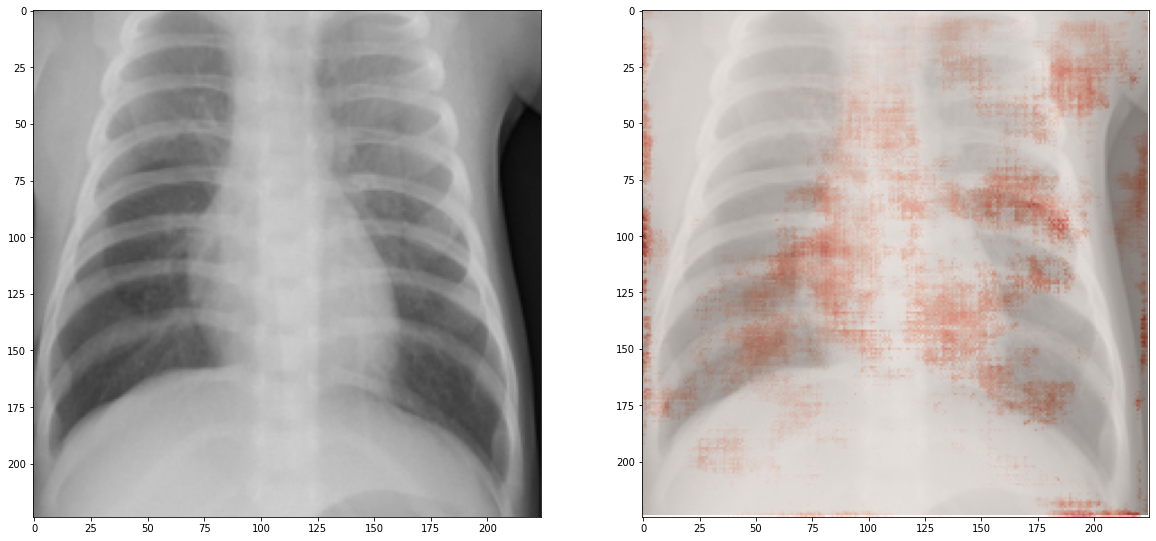

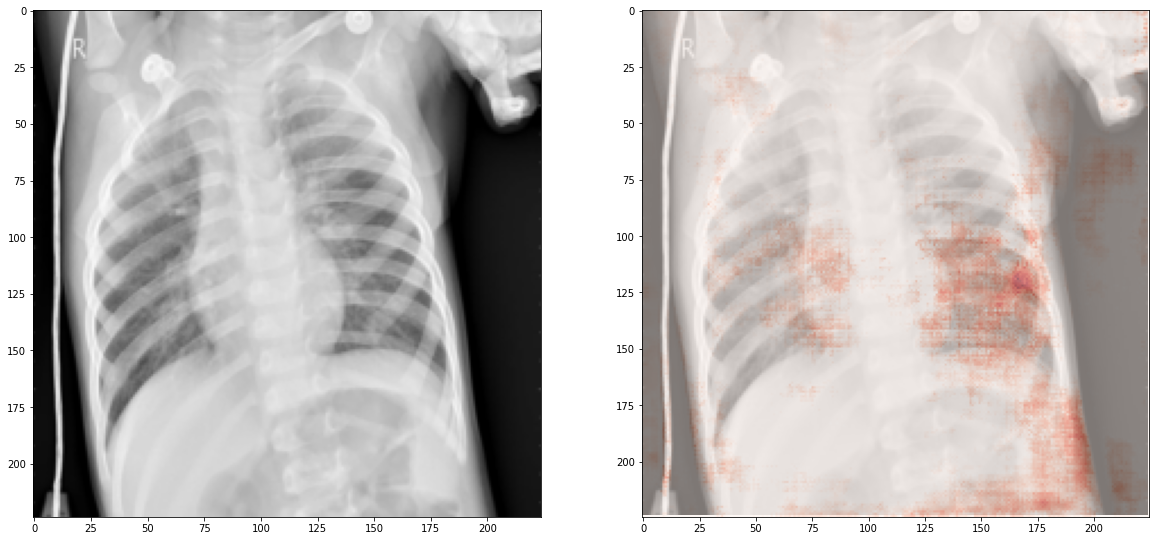

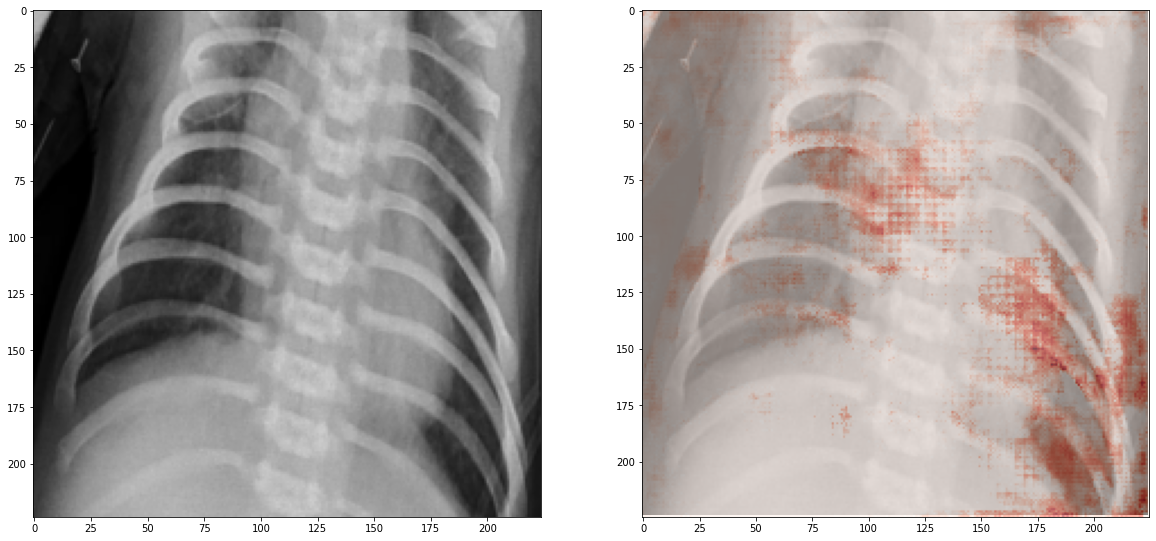

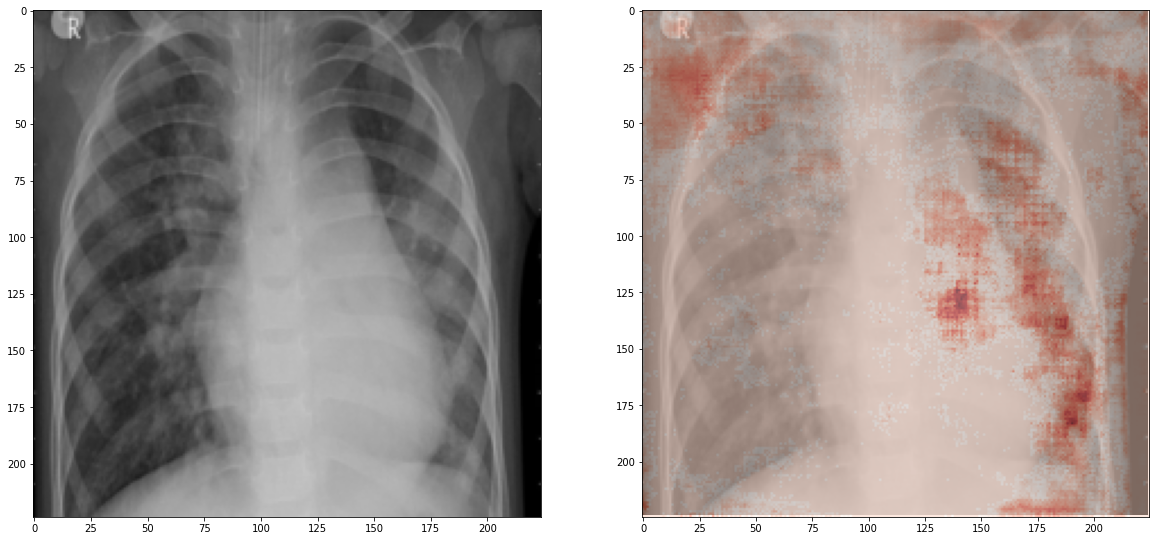

In [68]:
def iamshow(img): 
    for i in range(3):
        img[i] -= mean[i]    
        img[i] /= std[i]    
    plt.imshow(np.transpose(img, (1, 2, 0)))  
    
for i, ii in enumerate(diffmap):
    if label[i] != 1:
        continue
    im = ii.cpu().data.numpy()
    # im = im - np.mean(im)  #
    im[im<np.mean(im)] = 0
    plt.figure(figsize=(20,20))
    plt.subplot(1,2,1)
    ishow(torch.squeeze(img[i]).cpu().detach().numpy())
    plt.subplot(1,2,2)
    ishow(torch.squeeze(img[i]).cpu().detach().numpy())
    plt.imshow(im, cmap=plt.cm.jet, alpha=0.5)
    # plt.colorbar()